In [1]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

# Airline Arrivals

The purpose of this project is to predict flight arrival times. We will consider a flight that is delayed by 30 minutes or more as a late flight.

## The Data

The dataset contains information which someone who is trying to predict arrival times will not have. For example: "Reason for Cancellation". I will only import columns where it is reasonable to assume the information will be available before the flight will occur. The meat of this project will be creating useful features which help the model estimate flight arrival times.

In [2]:
file = 'C:\\Users\\Abe\\Data Science Bootcamp\\Unit 3\\Potpourrie\\Airplanes\\2008_20.csv'

# Import these columns
use_me = [
'Year',
'Month',
'DayofMonth',
'DayOfWeek',
'CRSDepTime',
'CRSArrTime',
'UniqueCarrier',
'Origin',
'Dest',
'ArrDelay'
]

df = pd.read_csv(file, usecols=use_me)
df.shape

(1401560, 10)

In [3]:
# Create Date Feature
df.rename(columns={'Year':'year','Month':'month','DayofMonth':'day','ArrDelay':'Delay'},inplace=True)
df['Date'] = pd.to_datetime(df[['year','month','day']])
df.drop('year',axis=1,inplace=True)
df.dropna(inplace=True)

# Combine Origin and Destination to create feature for route
df['Route'] = df['Origin'] + df['Dest']

# Look at percentage of delays
print('Total Percentage of Late Flights:')
df[df['Delay'] > 30].shape[0] / df.shape[0]

Total Percentage of Late Flights:


0.1319281845249818

In [4]:
categorical = df.select_dtypes(include=['object'])
for col in categorical:
    column_ = categorical[col]
    print(col)
    print(column_.nunique())

UniqueCarrier
20
Origin
301
Dest
302
Route
5033


In [5]:
# Create indicator column for late flights
df['late'] = df['Delay'] >= 30

## Daily Airport Data

The first place we should start is looking at daily airport traffic. It makes sense intuitively that when an airport is busy there will probably be more delays. We'll start by looking at the percentage of late flights per airport as traffic increases. We'll also look at how the average lateness changes as an airport has more flights.

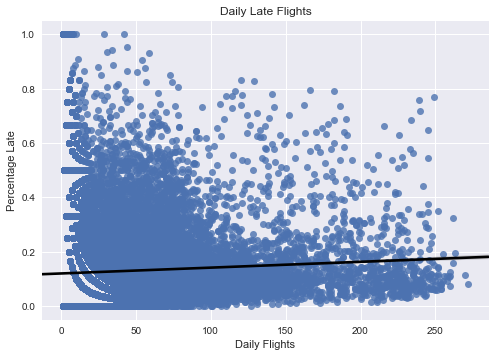

In [6]:
# Look at how the amount of daily traffic affects lateness at airports
flight_data = df[['Date','Origin','late']].groupby(by=['Date','Origin']).agg(['sum','count','mean'])
x=flight_data[('late','count')]
y=flight_data[('late','mean')]

sns.regplot(x=x, y=y,line_kws={'color':'black'})
plt.xlabel('Daily Flights')
plt.ylabel('Percentage Late')
plt.title('Daily Late Flights')
plt.show()

# Create features for number of flights / airport / day
late_flight_count = df[['Date','Origin','late']].groupby(by=['Date','Origin']).transform('sum')
flight_count = df[['Date','Origin','late']].groupby(by=['Date','Origin']).transform('count')

df['late_flights_per_origin_per_day'] = late_flight_count
df['flight_count_per_origin_per_day'] = flight_count
df['percent_late_flights_per_origin/day'] = late_flight_count / flight_count

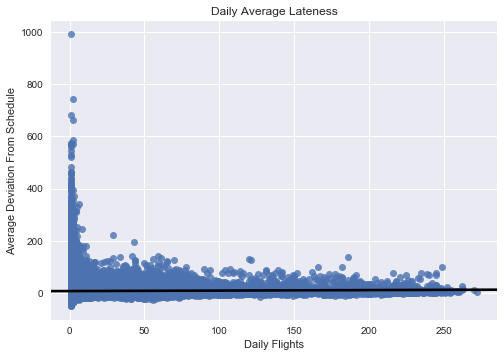

In [7]:
# Look at how the amount of daily traffic affects time delay at airports
# Similar to cell above but use continuous value for time instead of late indicator
flight_data = df[['Date','Origin','Delay']].groupby(by=['Date','Origin']).agg(['sum','count','mean'])
x=flight_data[('Delay','count')]
y=flight_data[('Delay','mean')]

sns.regplot(x=x, y=y,line_kws={'color':'black'})
plt.xlabel('Daily Flights')
plt.ylabel('Average Deviation From Schedule')
plt.title('Daily Average Lateness')
plt.show()

# Add feature to show 
AAD = df[['Date','Origin','Delay']].groupby(by=['Date','Origin']).transform('mean')
df['Average_Airport_Deviation_From_Schedule'] = AAD

## Aggregate Airport Data

Aggregate data can also be helpful when training our model. While daily data has more variance, we might be able to grab some low hanging fruit here by identifying airports which are consistantly delayed. Again, we will look at lateness as total airport traffic increases and create features to note if an airport is on the late end of the spectrum. We'll also look at route data to see if certain routes are later than others.

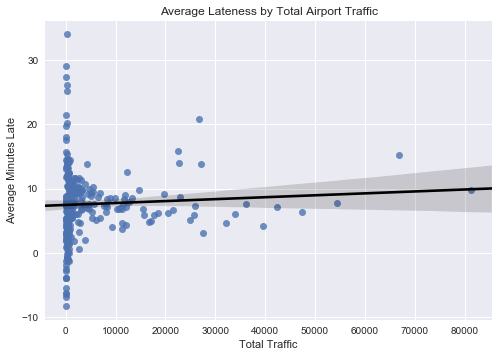

In [8]:
# Create data frames to calculate average delay per airport for origin and destinations
orig = df[['Origin','Delay']].groupby(by='Origin').agg(['mean','count'])
dest = df[['Dest','Delay']].groupby(by='Dest').agg(['mean','count'])

# Look at average lateness by the amount of traffic per airport
sns.regplot(x=dest[('Delay','count')],y=dest[('Delay','mean')], line_kws={'color':'black'})
plt.xlabel('Total Traffic')
plt.ylabel('Average Minutes Late')
plt.title('Average Lateness by Total Airport Traffic')
plt.show()

In [9]:
# Create indicator for airports which are more late on average
q3_dest = dest[('Delay','mean')].quantile(.75)
q3_orig = orig[('Delay','mean')].quantile(.75)

delayed_airports = orig[orig[('Delay','mean')] > q3_orig].index
delayed_airports.append(dest[dest[('Delay','mean')] > q3_dest].index)

df['delayed_airports'] = df['Dest'].isin(delayed_airports) | df['Origin'].isin(delayed_airports)

In [10]:
# Look at late Routes on average and create an indicator for if the route is late more than 75% of its peers
late_routes = df[['late','Route']].groupby(by='Route').mean()
q3_routes = late_routes[late_routes['late'] > late_routes['late'].quantile(.75)].index
df['Delayed_Routes'] = df['Route'].isin(q3_routes)

## Aggregate Carrier Data

Airport traffic can affect flight delays significantly, but some airlines are just better at staying on time than others. Better maintenance, employees and operations can all improve on-time flights. We'll make a feature which tells the model what each carriers average lateness is.

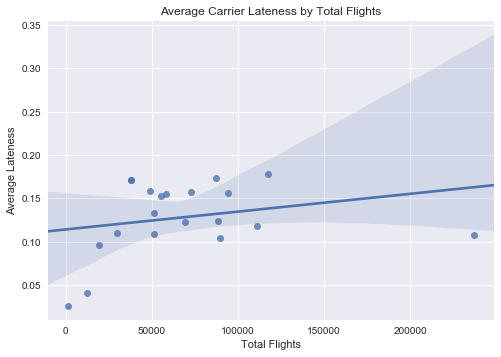

In [11]:
# Plot average lateness per carrier
late_carriers_plot = df[['late','UniqueCarrier']].groupby('UniqueCarrier').agg(['sum','count','mean'])
x = late_carriers_plot[('late','count')]
y = late_carriers_plot[('late','mean')]

sns.regplot(x=x,y=y)
plt.xlabel('Total Flights')
plt.ylabel('Average Lateness')
plt.title('Average Carrier Lateness by Total Flights')
plt.show()

# Create columns for total late flights per carrier, total flights per carrier and average late flights per carrier
late_carriers_sum = df[['late','UniqueCarrier']].groupby('UniqueCarrier').transform('sum')
late_carriers_count = df[['late','UniqueCarrier']].groupby('UniqueCarrier').transform('count')

df['late_carriers_avg'] = late_carriers_sum / late_carriers_count

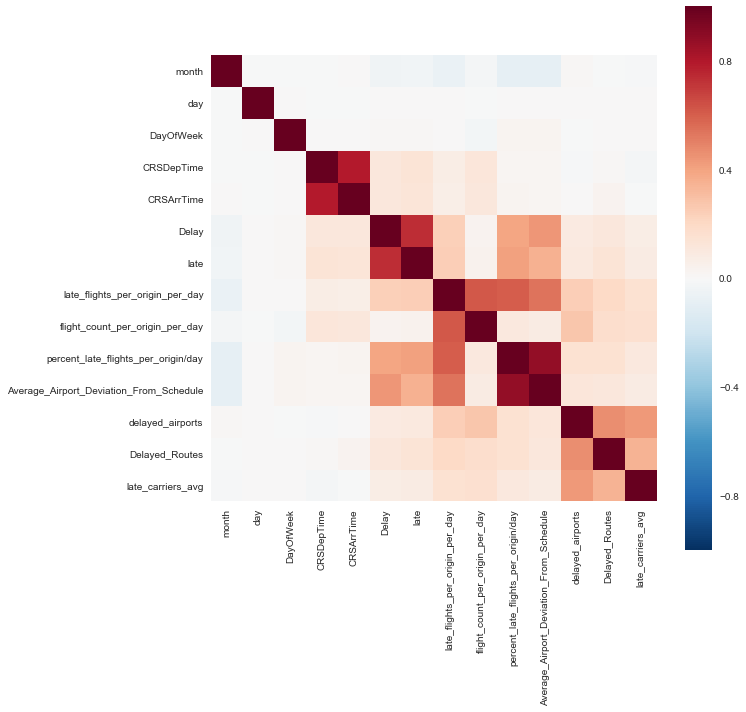

month                                     -0.040809
day                                        0.002612
DayOfWeek                                  0.010522
CRSDepTime                                 0.116868
CRSArrTime                                 0.113173
Delay                                      1.000000
late                                       0.737467
late_flights_per_origin_per_day            0.240045
flight_count_per_origin_per_day            0.036939
percent_late_flights_per_origin/day        0.390719
Average_Airport_Deviation_From_Schedule    0.443042
delayed_airports                           0.086229
Delayed_Routes                             0.116847
late_carriers_avg                          0.077793
Name: Delay, dtype: float64

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),square=True)
plt.show()

df.corr()['Delay']

## Delays by Month and Day of the Week

Airport traffic varies greatly by the months and by the days of the week. More people travel on holidays and over the weekends which increase the chances of flights being delayed. We'll look at this visually and then create features for the model by turning them into dummy variables.

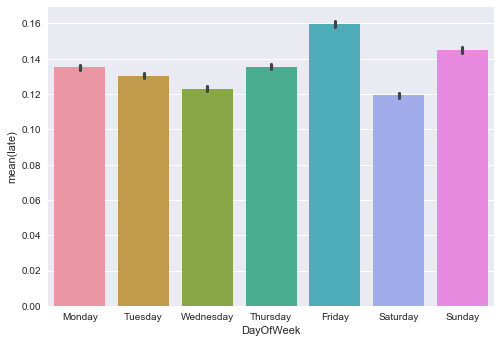

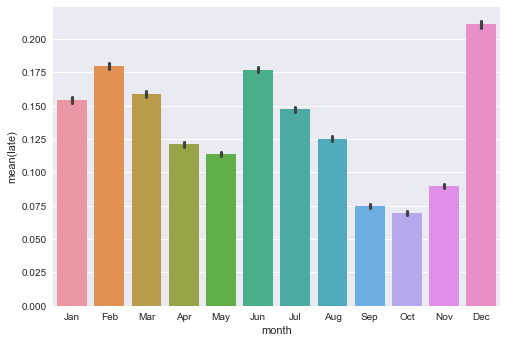

In [15]:
# Replace Numbers with Days and Months
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

df['DayOfWeek'].replace([1,2,3,4,5,6,7],days,inplace=True)
df['month'].replace([1,2,3,4,5,6,7,8,9,10,11,12],months,inplace=True)

sns.barplot(x=df['DayOfWeek'],y=df['late'],order=days)
plt.show()

sns.barplot(x=df['month'],y=df['late'],order=months)
plt.show()

In [16]:
# Drop columns which we don't want to run dummies on and other non-essential columns
drop_me = list(categorical.columns) + ['Date']
df.drop(drop_me,axis=1,inplace=True)
df.dropna(inplace=True)

## Statistical Tests

We will run two tests: One F test to determine if Day of the Week has a significant effect on flight delays and a chisquared test to check if the difference between the actual number of late flights per day are significantly different than the expected amount of late flights using the data set average of ~13%.

In [17]:
# Match lists for days and months to the names of the dummy variables in the df
days = ['DayOfWeek_' + day for day in days]
months = ['month_' + month for month in months]
cols = days + months

In [18]:
from scipy import stats

stats.f_oneway(*[values for category, values in df.groupby('DayOfWeek')['Delay']])

F_onewayResult(statistic=404.26863105841505, pvalue=0.0)

In [19]:
# Figure out how many flights were on each day
flights_per_day = df.groupby('DayOfWeek').size()

# Calculate the expected values for late flights using the average for the data set
exp_late_flights = (flights_per_day*.1319281845249818).astype(int)

# Create a variable which contains the actual amount of late flights 
actual_late_flights = df.groupby('DayOfWeek')['late'].sum().astype(int)

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

sorted_exp_late_flights = [exp_late_flights[day] for day in days]
sorted_actual_late_flights = [actual_late_flights[day] for day in days]

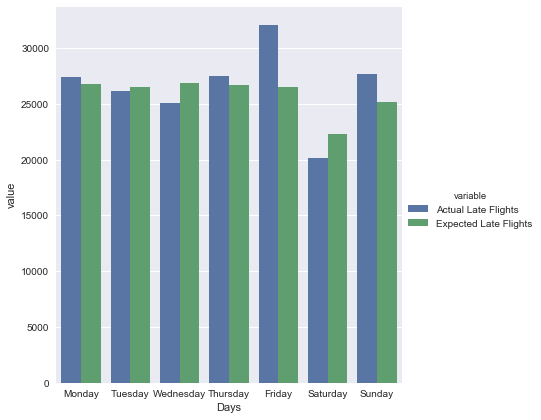

Power_divergenceResult(statistic=1793.9158470614718, pvalue=0.0)

In [20]:
# Plot the expected amount of late flights per day against the actual late flights for visual inspection
# Then run a chisquared test to determine if there is significance between them
df_plot = pd.DataFrame(data={'Days':days,
                             'Expected Late Flights':sorted_exp_late_flights,
                             'Actual Late Flights':sorted_actual_late_flights})
df_plot = pd.melt(df_plot,id_vars='Days')
sns.factorplot(x='Days',y='value',data=df_plot,hue='variable',kind='bar',size=6)
plt.show()

stats.chisquare(sorted_actual_late_flights, sorted_exp_late_flights)

In [21]:
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1370958 entries, 0 to 1401559
Data columns (total 31 columns):
day                                        1370958 non-null int64
CRSDepTime                                 1370958 non-null int64
CRSArrTime                                 1370958 non-null int64
Delay                                      1370958 non-null float64
late                                       1370958 non-null bool
late_flights_per_origin_per_day            1370958 non-null float64
flight_count_per_origin_per_day            1370958 non-null int64
percent_late_flights_per_origin/day        1370958 non-null float64
Average_Airport_Deviation_From_Schedule    1370958 non-null float64
delayed_airports                           1370958 non-null bool
Delayed_Routes                             1370958 non-null bool
late_carriers_avg                          1370958 non-null float64
month_Apr                                  1370958 non-null uint8
month_Aug             

## Models

We'll focus on decision tree based models.

In [22]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=10,
                                      max_features=None)

X = df.loc[:, df.columns != 'Delay']
y = df['Delay']

from sklearn.model_selection import cross_val_score

scre = cross_val_score(decision_tree, X, y, cv=5, scoring='neg_mean_absolute_error')
print(scre)
print(scre.mean())

[-13.92571365 -12.5560312  -13.65403212 -11.15722932 -13.01430319]
-12.8614618976


In [23]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(max_depth=10,
                               max_features=None)

X = df.loc[:, df.columns != 'Delay']
y = df['Delay']

from sklearn.model_selection import cross_val_score
scre = cross_val_score(forest, X, y, cv=5, scoring='neg_mean_absolute_error')
print(scre)
print(scre.mean())

[-13.76947889 -12.47044216 -13.54466729 -11.0771179  -12.91933598]
-12.7562084445


In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(max_depth=3,
                                  n_estimators=50)

X = df.loc[:, df.columns != 'Delay']
y = df['Delay']

from sklearn.model_selection import cross_val_score
scre = cross_val_score(gb_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print(scre)
print(scre.mean())

[-14.08615276 -12.70036797 -13.78474447 -11.37106748 -13.24123659]
-13.0367138553
